In [64]:
import numpy as np 
import pandas as pd 
import itertools 
import random

In [65]:
def calculate_variable_beliefs(M_factor_variable):
    """Funkcija za kalkulisanje verovanja za svaki variable node"""
    for column in range(M.shape[1]):
        messages = A.iloc[:,column].values
        # Uzimam ne nula elemente
        messages_idx = list(np.nonzero(messages)[0])
        # Idemo po nenula elementima
        for v in values:
            message_product = 1
            for incoming_message in messages_idx:
                message_product *= M_factor_variable[incoming_message, column, v]

            variable_beliefs[v, column] = np.exp(c[column] * v) * message_product
            
    display(variable_beliefs)
    print('Solution for vector x: ',np.argmax(variable_beliefs,axis=0))


def calculate_psi():
    """Kalkuliše Psi faktor za svaki faktor node"""
    psi_dict = {}
    for idx,row in A.iterrows():
        # For every constraint take variables that are figuring in it 
        columns = (list(A.columns[row != 0]))
        # Make combination for combination of different values for different variables
        combinations = list(itertools.product(values,repeat=len(columns)))

        # Create factors so that each factor sees when to we satisfy limitations
        df = pd.DataFrame(combinations, columns=columns)
        psi_values = df.dot(A.loc[idx,columns]) <= d[idx]
        df['psi'] =  psi_values
        psi_dict[f'psi_{idx+1}'] = df.set_index(list(df.columns[:-1]))
        
    return psi_dict


def run_belief_propagation(A, num_iterations = 10):
    """Treniranje Belief Propagation algoritma i izračunavanje"""
    M = np.dstack([A.copy(), A.copy()])
    M_factor_variable, M_variable_factor = M.copy(), M.copy()

    for iteration in range(num_iterations):
        #print('Iteration: ', iteration)
        for row in range(M.shape[0]):
            # Odgovarajuci faktor
            #display(psi_dict[f'psi_{row+1}'])

            # Idem po prvom redu
            messages = A.iloc[row].values
            #print(messages)

            # Uzimam ne nula elemente
            messages_idx = list(np.nonzero(messages)[0])
            #print('m_idx',messages_idx)

            # Idemo po nenula elementima
            for idx_column, column in enumerate(messages_idx):
                # Uzimamo sve nenula elemente iz niza osim onoga
                # po kom trenutno iteriramo
                incoming_messages = messages_idx[:idx_column] + messages_idx[idx_column+1:]
                #print("Incoming messages", incoming_messages)
                # Idemo po svim mogucim vrednostima koje varijabla moze da uzme
                for v in values:
                    ## #print('Trenutna vrendost za v: ',v)
                    ## #print('Saljemo poruku ka kojoj varijabli tj. koja nam je fiksirana v: ', j)
                    combinations = itertools.product(values, repeat = len(incoming_messages)+1)
                    ## #print('Full combinations:', combinations)
                    combinations = list(filter(lambda x: x[idx_column] == v,combinations))
                    #print('Filtered combinations: ', combinations)
                    for e in combinations:
                        #print(e)
                        incoming_idexes = e[:idx_column] + e[idx_column +1:]
                        #print('Incoming indexes: ',incoming_idexes)
                        psi = psi_dict[f'psi_{row + 1}'].loc[e].values.copy()
                        message_product = np.product(M_variable_factor[row, incoming_messages, incoming_idexes])
                        M_factor_variable[row, column, v] += psi * message_product

        sum_factor_variable = M_factor_variable.sum(axis=-1, keepdims = True)

        with np.errstate(divide='ignore', invalid='ignore'):
            M_factor_variable = np.true_divide(M_factor_variable, sum_factor_variable)
            M_factor_variable[~np.isfinite(M_factor_variable)] = 0


        for column in range(M.shape[1]):

            # Idem po prvom redu
            messages = A.iloc[:,column].values
            # #print(messages)

            # Uzimam ne nula elemente
            messages_idx = list(np.nonzero(messages)[0])
            # #print('m_idx',messages_idx)

            # Idemo po nenula elementima
            for index_row, row in enumerate(messages_idx):
                # Uzimamo sve nenula elemente iz niza osim onoga
                # po kom trenutno iteriramo
                incoming_messages = messages_idx[:index_row] + messages_idx[index_row+1:]
                # #print("Incoming messages", incoming_messages)
                # Idemo po svim mogucim vrednostima koje varijabla moze da uzme
                for v in values:

                    # Mnozimo sve dolazece poruke sa variable cvorova 
                    message_product = 1
                    for incoming_message in incoming_messages:
                        # Dolazece poruke za dato ogranicenje
                        ## #print('Indexes: ',incoming_message, column, v)
                        ## #print('Value of this: ',M_factor_variable[incoming_message, column, v])
                        message_product *= M_factor_variable[incoming_message, column, v].copy()

                    # #print('Message product: ', message_product)
                    # #print('Old value',M_variable_factor[row, column, v])
                    # #print('Value of c:', c[column])
                    M_variable_factor[row, column, v] += np.exp(c[column] * v) * message_product
                    # #print('New value',M_variable_factor[row, column, v])

        sum_variable_factor = M_variable_factor.sum(axis=-1, keepdims = True)

        with np.errstate(divide='ignore', invalid='ignore'):
            M_variable_factor = np.true_divide(M_variable_factor, sum_variable_factor)
            M_variable_factor[~np.isfinite(M_variable_factor)] = 0

        calculate_variable_beliefs(M_factor_variable)
     

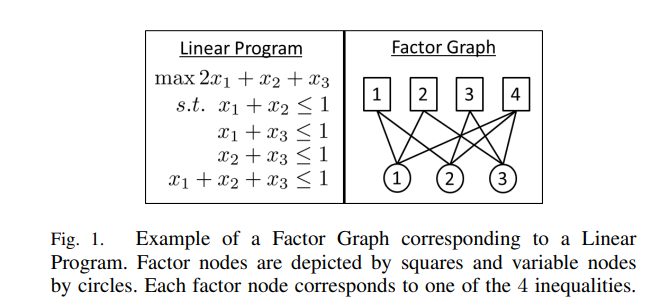

In [80]:
num_of_variables = 3 
columns = list(range(1,num_of_variables+1))
A = pd.DataFrame([[1,1,0],
             [1,0,1],
             [0,1,1],
             [1,1,1]],columns = columns)
d = pd.Series(data = [1,1,1,1])
c = np.array([15, 21, 40]) # Testirao sam algoritam sa različitim težinama 
values = [0,1]
variable_beliefs = np.zeros((len(values),len(c)))
M = np.dstack([A.copy(), A.copy()])
psi_dict = calculate_psi()

In [81]:
run_belief_propagation(A, num_iterations = 30)

array([[2.40000000e-01, 2.40000000e-01, 2.40000000e-01],
       [1.74347593e+05, 7.03368392e+07, 1.25538809e+16]])

Solution for vector x:  [1 1 1]


array([[4.26666666e-01, 4.26666585e-01, 4.26666585e-01],
       [4.35868986e+04, 1.75842569e+07, 3.13847865e+15]])

Solution for vector x:  [1 1 1]


array([[5.40000002e-01, 5.40000902e-01, 5.40000904e-01],
       [1.08967248e+04, 4.39609111e+06, 7.84624474e+14]])

Solution for vector x:  [1 1 1]


array([[6.01666685e-01, 6.01674017e-01, 6.01674035e-01],
       [2.72418139e+03, 1.09905303e+06, 1.96161532e+14]])

Solution for vector x:  [1 1 1]


array([[6.33750100e-01, 6.33790201e-01, 6.33790301e-01],
       [6.81045544e+02, 2.74795194e+05, 4.90460971e+13]])

Solution for vector x:  [1 1 1]


array([[6.50104631e-01, 6.50291154e-01, 6.50291617e-01],
       [1.70261587e+02, 6.87315709e+04, 1.22673881e+13]])

Solution for vector x:  [1 1 1]


array([[6.58361374e-01, 6.59162748e-01, 6.59164730e-01],
       [4.25656015e+01, 1.72160711e+04, 3.07278359e+12]])

Solution for vector x:  [1 1 1]


array([[6.62514785e-01, 6.65795056e-01, 6.65803043e-01],
       [1.06416082e+01, 4.33735286e+03, 7.74160930e+11]])

Solution for vector x:  [1 1 1]


array([[6.64618267e-01, 6.77272033e-01, 6.77300998e-01],
       [2.66061839e+00, 1.11756619e+03, 1.99487774e+11]])

Solution for vector x:  [1 1 1]


array([[6.65753588e-01, 7.08080569e-01, 7.08155188e-01],
       [6.65401305e-01, 3.11775810e+02, 5.56748861e+10]])

Solution for vector x:  [0 1 1]


array([[6.66582673e-01, 7.71166155e-01, 7.71189567e-01],
       [1.66698859e-01, 1.06944326e+02, 1.91369593e+10]])

Solution for vector x:  [0 1 1]


array([[6.67545641e-01, 8.47898878e-01, 8.47412970e-01],
       [4.22838042e-02, 4.80694654e+01, 8.67341285e+09]])

Solution for vector x:  [0 1 1]


array([[6.68703598e-01, 9.09673075e-01, 9.08286627e-01],
       [1.16925105e-02, 2.47816397e+01, 4.54966009e+09]])

Solution for vector x:  [0 1 1]


array([[6.69914064e-01, 9.47988608e-01, 9.46062612e-01],
       [5.02478512e-03, 1.29885055e+01, 2.35507953e+09]])

Solution for vector x:  [0 1 1]


array([[6.71063251e-01, 9.66840079e-01, 9.67026587e-01],
       [5.29273184e-03, 6.67821863e+00, 9.37434767e+08]])

Solution for vector x:  [0 1 1]


array([[6.71949029e-01, 9.71147321e-01, 9.79819748e-01],
       [9.18959932e-03, 3.35184568e+00, 2.44075990e+08]])

Solution for vector x:  [0 1 1]


array([[6.71828682e-01, 9.62643659e-01, 9.87469338e-01],
       [1.76365968e-02, 1.63662291e+00, 5.67353736e+07]])

Solution for vector x:  [0 1 1]


array([[6.67915899e-01, 9.39807711e-01, 9.91621582e-01],
       [3.36231955e-02, 7.70275328e-01, 1.48750203e+07]])

Solution for vector x:  [0 0 1]


array([[6.51413644e-01, 8.99983952e-01, 9.93690360e-01],
       [5.92877483e-02, 3.44700368e-01, 4.84685835e+06]])

Solution for vector x:  [0 0 1]


array([[6.06596974e-01, 8.43377564e-01, 9.94549326e-01],
       [8.43469509e-02, 1.45003404e-01, 1.99683886e+06]])

Solution for vector x:  [0 0 1]


array([[5.34904419e-01, 7.76135596e-01, 9.94623103e-01],
       [8.50638956e-02, 5.70064318e-02, 1.01928464e+06]])

Solution for vector x:  [0 0 1]


array([[4.64283140e-01, 7.08418249e-01, 9.94007180e-01],
       [6.33507555e-02, 2.08226924e-02, 6.31443824e+05]])

Solution for vector x:  [0 0 1]


array([[4.13426765e-01, 6.49031630e-01, 9.92495710e-01],
       [3.90114103e-02, 7.04458428e-03, 4.73552216e+05]])

Solution for vector x:  [0 0 1]


array([[3.83342680e-01, 6.02158113e-01, 9.89516165e-01],
       [2.15612848e-02, 2.21785588e-03, 4.32476281e+05]])

Solution for vector x:  [0 0 1]


array([[3.68630041e-01, 5.67825540e-01, 9.83944978e-01],
       [1.11851038e-02, 6.56938625e-04, 4.79108267e+05]])

Solution for vector x:  [0 0 1]


array([[3.64527968e-01, 5.43925101e-01, 9.73809085e-01],
       [5.55270496e-03, 1.85537487e-04, 6.32372075e+05]])

Solution for vector x:  [0 0 1]


array([[3.68546061e-01, 5.27848544e-01, 9.56049511e-01],
       [2.64482232e-03, 5.06250646e-05, 9.72474765e+05]])

Solution for vector x:  [0 0 1]


array([[3.79818256e-01, 5.17294266e-01, 9.26919442e-01],
       [1.19788082e-03, 1.35048875e-05, 1.71980042e+06]])

Solution for vector x:  [0 0 1]


array([[3.97553670e-01, 5.10500840e-01, 8.83818025e-01],
       [5.08101641e-04, 3.55851036e-06, 3.51090615e+06]])

Solution for vector x:  [0 0 1]


array([[4.19520027e-01, 5.06215583e-01, 8.28070561e-01],
       [1.99051577e-04, 9.33363711e-07, 8.36538453e+06]])

Solution for vector x:  [0 0 1]


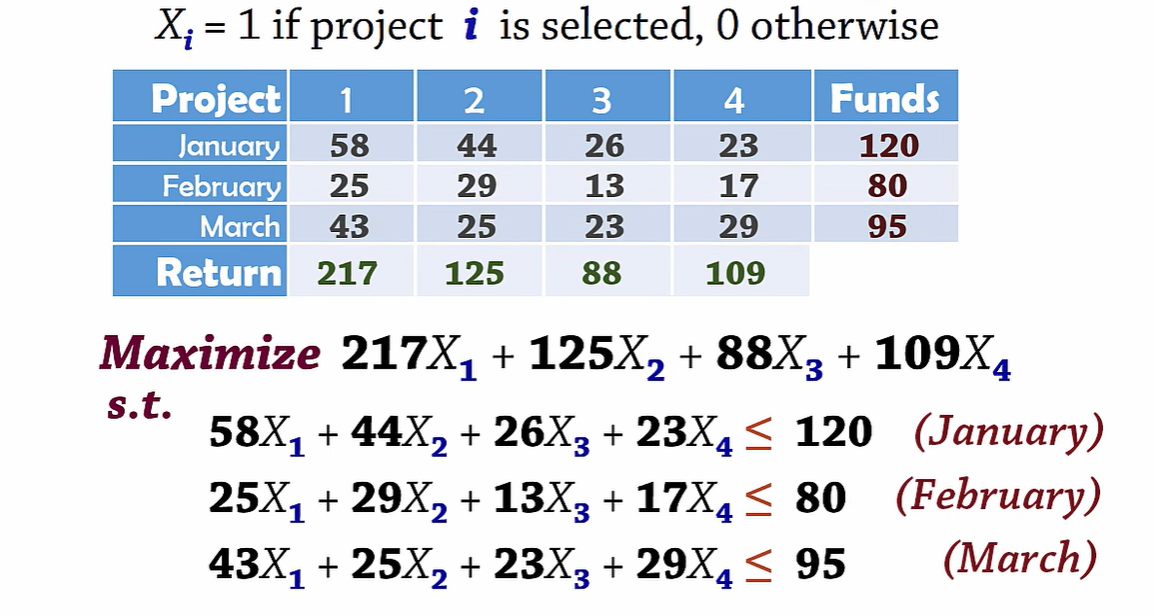

In [83]:
num_of_variables = 4
columns = list(range(1,num_of_variables+1))
A = pd.DataFrame([[58, 44, 26, 23],
                 [25, 29, 13, 17],
                 [43, 25, 23, 29]], columns = columns)
d = pd.Series(data = [120, 80, 95])
c = np.array([217, 125, 88, 109])
c = c / c.min()
values = [0,1]
variable_beliefs = np.zeros((len(values),len(c)))
M = np.dstack([A.copy(), A.copy()])
psi_dict = calculate_psi()

In [85]:
run_belief_propagation(A, num_iterations = 10)

array([[0.18751914, 0.18752781, 0.14358778, 0.16409604],
       [0.90588758, 0.31842587, 0.29274265, 0.31856081]])

Solution for vector x:  [1 1 1 1]


array([[0.18753599, 0.18854441, 0.14384444, 0.16473246],
       [0.90577324, 0.31597936, 0.29213876, 0.31701923]])

Solution for vector x:  [1 1 1 1]


array([[0.21322212, 0.23978365, 0.15700168, 0.19417762],
       [0.7472187 , 0.21435703, 0.26269465, 0.25452933]])

Solution for vector x:  [1 0 1 1]


array([[0.22910514, 0.28139554, 0.16507452, 0.21239861],
       [0.66192873, 0.15502866, 0.24593294, 0.22267155]])

Solution for vector x:  [1 0 1 1]


array([[0.23053745, 0.30189566, 0.16659288, 0.21456751],
       [0.65156035, 0.13058952, 0.24271927, 0.2192632 ]])

Solution for vector x:  [1 0 1 1]


array([[0.2256624 , 0.31077598, 0.16516858, 0.20950556],
       [0.67247377, 0.12029392, 0.24530918, 0.22760147]])

Solution for vector x:  [1 0 1 1]


array([[0.22030299, 0.31637483, 0.16319425, 0.2034765 ],
       [0.69743806, 0.11395619, 0.24910279, 0.23789826]])

Solution for vector x:  [1 0 1 1]


array([[0.21616763, 0.32168359, 0.16142057, 0.19844537],
       [0.71752326, 0.10845185, 0.25264207, 0.24684754]])

Solution for vector x:  [1 0 1 1]


array([[0.21314991, 0.32700678, 0.1599091 , 0.19449876],
       [0.73264014, 0.10339533, 0.25576081, 0.25411714]])

Solution for vector x:  [1 0 1 1]


array([[0.21081678, 0.33203777, 0.15858805, 0.19133533],
       [0.74471464, 0.09895154, 0.25855742, 0.26011507]])

Solution for vector x:  [1 0 1 1]


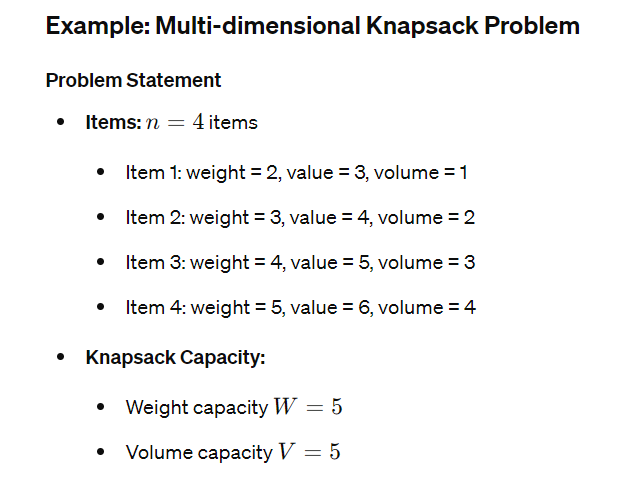

In [87]:
num_of_variables = 4
columns = list(range(1,num_of_variables+1))
A = pd.DataFrame([[2, 3, 4, 5],
                 [1, 2, 3, 4]], columns = columns)
d = pd.Series(data = [5, 5])
c = np.array([3, 4, 5, 6])
values = [0,1]
variable_beliefs = np.zeros((len(values),len(c)))
M = np.dstack([A.copy(), A.copy()])
psi_dict = calculate_psi()

In [88]:
run_belief_propagation(A, num_iterations = 30)

array([[ 0.36901401,  0.43779036,  0.53559738,  0.60222036],
       [ 2.99541592,  6.2500931 ,  9.29100382, 19.60525348]])

Solution for vector x:  [1 1 1 1]


array([[ 0.38075681,  0.46429176,  0.57133916,  0.65476857],
       [ 2.86679709,  5.52653835,  7.8809084 , 14.55637959]])

Solution for vector x:  [1 1 1 1]


array([[ 0.38393183,  0.47287006,  0.58424991,  0.68014144],
       [ 2.83421954,  5.29502927,  7.43736633, 12.38775247]])

Solution for vector x:  [1 1 1 1]


array([[ 0.38703216,  0.48074513,  0.59617083,  0.70168848],
       [ 2.80249491,  5.08344891,  7.03130035, 10.61526208]])

Solution for vector x:  [1 1 1 1]


array([[0.39017712, 0.48843951, 0.60791143, 0.72092324],
       [2.77029539, 4.87789376, 6.63470285, 9.09604383]])

Solution for vector x:  [1 1 1 1]


array([[0.39337423, 0.49598954, 0.61954756, 0.73821861],
       [2.73754333, 4.67753197, 6.24595895, 7.79057391]])

Solution for vector x:  [1 1 1 1]


array([[0.39663047, 0.50341479, 0.63112322, 0.75383871],
       [2.70417426, 4.48198141, 5.86466496, 6.66956936]])

Solution for vector x:  [1 1 1 1]


array([[0.3999534 , 0.51073431, 0.64267919, 0.76800729],
       [2.67012013, 4.29088768, 5.49060808, 5.70801986]])

Solution for vector x:  [1 1 1 1]


array([[0.40335126, 0.51796726, 0.65425313, 0.78091727],
       [2.63530905, 4.1039093 , 5.1237395 , 4.88426962]])

Solution for vector x:  [1 1 1 1]


array([[0.40683301, 0.52513285, 0.66587824, 0.79273499],
       [2.59966556, 3.92071939, 4.76419592, 4.17954981]])

Solution for vector x:  [1 1 1 1]


array([[0.41040828, 0.5322502 , 0.67758142, 0.80360352],
       [2.56311113, 3.74100913, 4.41232264, 3.57760129]])

Solution for vector x:  [1 1 1 1]


array([[0.41408747, 0.5393381 , 0.68938125, 0.8136454 ],
       [2.52556503, 3.56449268, 4.06869345, 3.06434841]])

Solution for vector x:  [1 1 1 1]


array([[0.41788164, 0.54641461, 0.70128564, 0.82296513],
       [2.48694577, 3.39091371, 3.73412411, 2.62761471]])

Solution for vector x:  [1 1 1 1]


array([[0.42180241, 0.55349659, 0.71328954, 0.8316512 ],
       [2.44717312, 3.22005412, 3.40967531, 2.25687438]])

Solution for vector x:  [1 1 1 1]


array([[0.42586184, 0.56059893, 0.72537268, 0.83977791],
       [2.40617096, 3.05174526, 3.09664053, 1.94303478]])

Solution for vector x:  [1 1 1 1]


array([[0.43007205, 0.56773371, 0.73749783, 0.84740695],
       [2.36387112, 2.88588213, 2.7965138 , 1.67824518]])

Solution for vector x:  [1 1 1 1]


array([[0.4344449 , 0.57490894, 0.74960985, 0.85458876],
       [2.32021833, 2.72244093, 2.51093333, 1.455728  ]])

Solution for vector x:  [1 1 1 1]


array([[0.43899133, 0.58212718, 0.761636  , 0.86136378],
       [2.27517627, 2.56149981, 2.24159858, 1.26962851]])

Solution for vector x:  [1 1 1 1]


array([[0.44372068, 0.58938391, 0.77348791, 0.86776365],
       [2.22873452, 2.40326265, 1.99016206, 1.11487999]])

Solution for vector x:  [1 1 1 1]


array([[0.44863975, 0.59666573, 0.78506534, 0.87381235],
       [2.18091601, 2.24808414, 1.75810179, 0.98708135]])

Solution for vector x:  [1 1 1 1]


array([[0.45375187, 0.60394878, 0.79626191, 0.87952741],
       [2.13178393, 2.0964936 , 1.54658659, 0.8823857 ]])

Solution for vector x:  [1 1 1 1]


array([[0.45905594, 0.61119739, 0.80697211, 0.8849212 ],
       [2.08144709, 1.9492128 , 1.35635185, 0.79739932]])

Solution for vector x:  [1 1 1 0]


array([[0.46454567, 0.61836365, 0.817099  , 0.89000243],
       [2.03006203, 1.80716148, 1.18760621, 0.72909262]])

Solution for vector x:  [1 1 1 0]


array([[0.47020915, 0.6253881 , 0.82656127, 0.89477761],
       [1.97783086, 1.67144274, 1.03998836, 0.67472671]])

Solution for vector x:  [1 1 1 0]


array([[0.47602891, 0.63220204, 0.83529855, 0.89925255],
       [1.92499441, 1.54330136, 0.9125853 , 0.63180054]])

Solution for vector x:  [1 1 1 0]


array([[0.48198243, 0.63873138, 0.84327406, 0.90343374],
       [1.87182158, 1.42405154, 0.80401129, 0.5980233 ]])

Solution for vector x:  [1 1 0 0]


array([[0.4880429 , 0.644902  , 0.85047425, 0.9073292 ],
       [1.81859743, 1.31497737, 0.71253334, 0.57131358]])

Solution for vector x:  [1 1 0 0]


array([[0.49418013, 0.65064563, 0.85690592, 0.91094899],
       [1.76561283, 1.21721809, 0.63621917, 0.54982104]])

Solution for vector x:  [1 1 0 0]


array([[0.50036112, 0.65590563, 0.86259173, 0.91430504],
       [1.71315828, 1.13165666, 0.57308139, 0.53195991]])

Solution for vector x:  [1 1 0 0]


array([[0.50655041, 0.66064137, 0.86756524, 0.91741073],
       [1.66152227, 1.05883244, 0.52119701, 0.51643971]])

Solution for vector x:  [1 1 0 0]


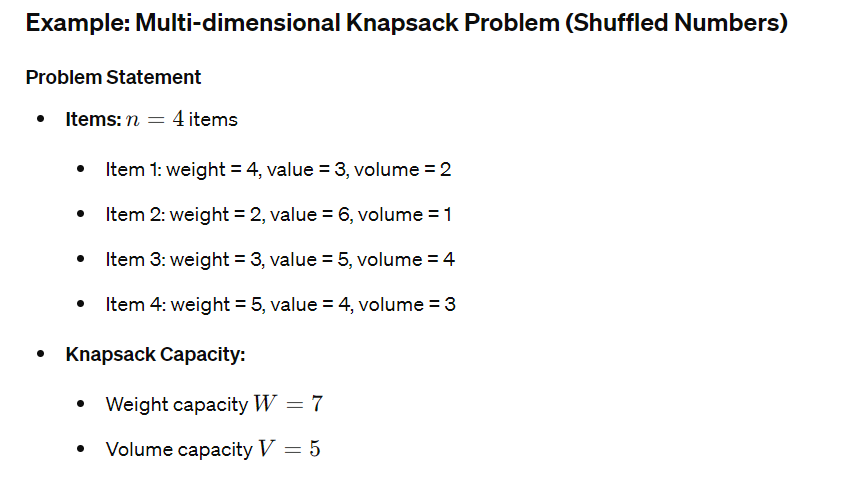

In [91]:
num_of_variables = 4
columns = list(range(1,num_of_variables+1))
A = pd.DataFrame([[2, 1, 4, 3],
                 [4, 2, 3, 5]], columns = columns)
d = pd.Series(data = [5, 7])
c = np.array([3, 6, 5, 4])
values = [0,1]
variable_beliefs = np.zeros((len(values),len(c)))
M = np.dstack([A.copy(), A.copy()])
psi_dict = calculate_psi()

In [92]:
run_belief_propagation(A, num_iterations = 30)

array([[ 0.4373073 ,  0.30813208,  0.49259651,  0.50051055],
       [ 2.30426316, 79.85435357, 12.87136864,  4.43215071]])

Solution for vector x:  [1 1 1 1]


array([[ 0.51410216,  0.33515931,  0.57866582,  0.58259881],
       [ 1.60849993, 71.44133445,  8.36482472,  2.89083312]])

Solution for vector x:  [1 1 1 1]


array([[ 0.54582513,  0.34648403,  0.62865581,  0.62729839],
       [ 1.37025348, 68.08996859,  6.2720995 ,  2.23173967]])

Solution for vector x:  [1 1 1 1]


array([[ 0.57696383,  0.35779134,  0.67107262,  0.66663422],
       [ 1.16043855, 64.85608715,  4.78132865,  1.74052538]])

Solution for vector x:  [1 1 1 1]


array([[ 0.60966773,  0.36967204,  0.70928735,  0.70380525],
       [ 0.96381703, 61.56944987,  3.64680924,  1.34331641]])

Solution for vector x:  [1 1 1 1]


array([[ 0.64349563,  0.38176907,  0.74270551,  0.73860062],
       [ 0.78417182, 58.33507009,  2.80357249,  1.02601376]])

Solution for vector x:  [1 1 1 1]


array([[ 0.67762395,  0.39356511,  0.77032756,  0.77035234],
       [ 0.62562735, 55.28436147,  2.20375046,  0.77951291]])

Solution for vector x:  [0 1 1 1]


array([[ 0.71098537,  0.40438282,  0.79122278,  0.79836688],
       [ 0.49115195, 52.56746012,  1.80469527,  0.59409682]])

Solution for vector x:  [0 1 1 0]


array([[ 0.74241919,  0.41344019,  0.8047602 ,  0.82213816],
       [ 0.38179991, 50.337004  ,  1.56987388,  0.45898081]])

Solution for vector x:  [0 1 1 0]


array([[ 0.77093922,  0.41999058,  0.81084053,  0.84155719],
       [ 0.29630041, 48.72068207,  1.47013999,  0.36285217]])

Solution for vector x:  [0 1 1 0]


array([[ 0.79600916,  0.42350676,  0.8100475 ,  0.85703047],
       [ 0.23134636, 47.79371174,  1.4832298 ,  0.29487482]])

Solution for vector x:  [0 1 1 0]


array([[ 0.8176361 ,  0.42381729,  0.80358117,  0.86938331],
       [ 0.18259303, 47.56560797,  1.5914182 ,  0.24578013]])

Solution for vector x:  [0 1 1 0]


array([[ 0.83621408,  0.42111722,  0.79294648,  0.87956937],
       [ 0.14582952, 47.98812868,  1.77920119,  0.20861502]])

Solution for vector x:  [0 1 1 0]


array([[ 0.85226555,  0.4158613 ,  0.77956474,  0.88838086],
       [ 0.11769647, 48.97758999,  2.03281444,  0.17885961]])

Solution for vector x:  [0 1 1 0]


array([[ 0.86626213,  0.4086213 ,  0.76452442,  0.89632562],
       [ 0.09580468, 50.43745622,  2.34117059,  0.15395893]])

Solution for vector x:  [0 1 1 0]


array([[ 0.87856746,  0.3999787 ,  0.74853912,  0.90366273],
       [ 0.07852853, 52.27198819,  2.69655097,  0.13261437]])

Solution for vector x:  [0 1 1 0]


array([[ 0.88944862,  0.39046858,  0.73203432,  0.91049657],
       [ 0.06475357, 54.39099956,  3.09424245,  0.11417739]])

Solution for vector x:  [0 1 1 0]


array([[8.99104171e-01, 3.80556765e-01, 7.15261987e-01, 9.16857560e-01],
       [5.36905111e-02, 5.67102479e+01, 3.53144484e+00, 9.82744138e-02]])

Solution for vector x:  [0 1 1 0]


array([[9.07687405e-01, 3.70631164e-01, 6.98389317e-01, 9.22750459e-01],
       [4.47598001e-02, 5.91512504e+01, 4.00606688e+00, 8.46259539e-02]])

Solution for vector x:  [0 1 1 0]


array([[9.15321600e-01, 3.60998351e-01, 6.81550885e-01, 9.28176984e-01],
       [3.75232210e-02, 6.16420665e+01, 4.51578991e+00, 7.29790233e-02]])

Solution for vector x:  [0 1 1 0]


array([[9.22109335e-01, 3.51883791e-01, 6.64872588e-01, 9.33143972e-01],
       [3.16423209e-02, 6.41189927e+01, 5.05750043e+00, 6.30908636e-02]])

Solution for vector x:  [0 1 1 0]


array([[9.28138328e-01, 3.43436252e-01, 6.48478782e-01, 9.37664913e-01],
       [2.68517740e-02, 6.65284621e+01, 5.62704512e+00, 5.47304620e-02]])

Solution for vector x:  [0 1 1 0]


array([[9.33485268e-01, 3.35736626e-01, 6.32491203e-01, 9.41759029e-01],
       [2.29413470e-02, 6.88284240e+01, 6.21922261e+00, 4.76835513e-02]])

Solution for vector x:  [0 1 1 0]


array([[9.38218450e-01, 3.28810224e-01, 6.17024841e-01, 9.45449746e-01],
       [1.97431590e-02, 7.09887597e+01, 6.82793502e+00, 4.17563722e-02]])

Solution for vector x:  [0 1 1 0]


array([[9.42399592e-01, 3.22640778e-01, 6.02183328e-01, 9.48763224e-01],
       [1.71223983e-02, 7.29906480e+01, 7.44644148e+00, 3.67773519e-02]])

Solution for vector x:  [0 1 1 0]


array([[9.46085049e-01, 3.17184219e-01, 5.88055058e-01, 9.51727119e-01],
       [1.49703988e-02, 7.48250820e+01, 8.06766953e+00, 3.25970681e-02]])

Solution for vector x:  [0 1 1 0]


array([[9.49326591e-01, 3.12380697e-01, 5.74710477e-01, 9.54369598e-01],
       [1.31993683e-02, 7.64908930e+01, 8.68454689e+00, 2.90870759e-02]])

Solution for vector x:  [0 1 1 0]


array([[9.52171857e-01, 3.08163935e-01, 5.62200681e-01, 9.56718583e-01],
       [1.17382966e-02, 7.79926558e+01, 9.29032066e+00, 2.61380856e-02]])

Solution for vector x:  [0 1 1 0]


array([[9.54664619e-01, 3.04467716e-01, 5.50557257e-01, 9.58801180e-01],
       [1.05297249e-02, 7.93387673e+01, 9.87883580e+00, 2.36578441e-02]])

Solution for vector x:  [0 1 1 0]


array([[9.56844931e-01, 3.01229803e-01, 5.39793202e-01, 9.60643269e-01],
       [9.52715951e-03, 8.05398687e+01, 1.04447520e+01, 2.15689541e-02]])

Solution for vector x:  [0 1 1 0]
